In [1]:
import astropy.units as u
import numpy as np
import popsims
import matplotlib.pyplot as plt
import astropy.coordinates as astro_coord
import glob
import pandas as pd

import itertools
from scipy import stats

from popsims.plot_style import  plot_style
plot_style()

#from shapey import Box
#paths
path_plot ='../figures/'
path_data = '../data/stream/'
isochrone_path='../data/isochrones/'
path_pipeline= '../data/pipeline/'

import warnings
warnings.filterwarnings("ignore")
from scipy.interpolate import UnivariateSpline

In [2]:
def read_backgrounds_file(m, rgc):
    
    fls= glob.glob('../data/backgrounds/*rgc{}*maglimit{}*'.format(rgc, m))
    
    res=[]
    for f in fls:
        #print (f)
        c=np.load(f, allow_pickle=True)
        for vls in c:
            #print (vls)
            dct={}
            for k in list(vls.keys()):
                dct['dmod']=float(k.split('galaxy')[-1])
                dct['run']=f.split('run')[-1].split('.npy')[0]
                for ks in (vls[k].keys()):
                    dct[ks]=vls[k][ks]
                    
                data= vls[k]['data']
                area= (data[0].max()-data[0].min())*(data[1].max()-data[1].min())
                dct['density']= len(data[0])/area
                dct['area']=area
                res.append(dct)
               
    
    return pd.DataFrame(res)


In [128]:
#functions
def show_gap_detection(vld,  plot='None', ax=None):
    try:
        #define
        meshgrid= vld['meshgrid']
        data=vld['data']
        grid_data = np.hstack([ xi.ravel().reshape(-1,1) for xi in meshgrid])
        gap_mask = vld['max_eigen'] > np.percentile(vld['max_eigen'],90. ) 
        
        #stream_mask =np.logical_or(vld['min_eigen'] < np.percentile(vld['min_eigen'],10.),
        #                            vld['density'] > np.percentile(vld['density'].flatten(), 90))
        
        stream_mask =vld['min_eigen'] < np.percentile(vld['min_eigen'],10.)
        
        stream_size=1.5*np.nanstd(meshgrid[1][stream_mask])
        #stream_size=0.5

    
        #fit a polynomial that is weighted by the density
        #print (len(meshgrid[0]))
        #print (len(s))

        pol=np.poly1d(np.polyfit(meshgrid[0][stream_mask], meshgrid[1][stream_mask], 2))
        #pol=UnivariateSpline(meshgrid[0][stream_mask], meshgrid[1][stream_mask])
        

        #define stream track and gap track
        stream_track=np.abs(grid_data[:,1] - pol(grid_data[:,0]))< stream_size/2
        #redefine the stream track as a check (just a random place at 0.5 pc from the center)

        gap_center=(np.nanmedian(meshgrid[0][gap_mask]), np.nanmedian(meshgrid[1][gap_mask]))

        gap_track=np.logical_and.reduce([np.abs((grid_data[:,0]-gap_center[0])) <0.5,
                                        stream_track])

       
        
        data_df=pd.DataFrame()
        data_df['x']=data[:,0]
        data_df['y']=data[:,1]
        
        grid_df=pd.DataFrame()
        grid_df['x']= grid_data[:,0]
        grid_df['y']= grid_data[:,1]
        
        stream_track_on_data=(np.abs(pol( data_df.x)-data_df.y)<stream_size/2).values
        gap_track_on_data=np.logical_and.reduce([np.abs((data[:,0]-gap_center[0])) <0.5,
                                               stream_track_on_data ])

        nstars_stream=len( data_df[stream_track_on_data])
        nstars_bck=len( data_df[~stream_track_on_data])
        nstars_gap=len( data_df[gap_track_on_data])

        #verify
        #stream_area=10*len( grid_df[stream_track])/len(grid_df)
        st_area= stream_size*5
        bck_area=10*len( grid_df[~stream_track])/len(grid_df)
        
        #gap_area=10*len(grid_df[gap_track])/len(grid_df)
        gap_area= stream_size*0.5
        
        if plot=='show_mask_data':
            ax.scatter(data_df.x, data_df.y,  s=10, alpha=0.1, c='k')
            ax.scatter(data_df.x[stream_track_on_data], data_df.y[stream_track_on_data],  s=10, alpha=0.1, c='r', label='Stream')
            ax.scatter(data_df.x[gap_track_on_data], data_df.y[gap_track_on_data],  s=10, alpha=0.1, c='b', label='Gap')
        
        if plot=='show_mask_grid':
            ax.scatter(grid_df.x, grid_df.y,  s=1, alpha=1, c='k')
            ax.scatter(grid_df.x[stream_track], grid_df.y[stream_track],  s=10, alpha=1, c='r', label='Stream')
            ax.scatter(grid_df.x[gap_track], grid_df.y[gap_track],  s=10, alpha=1, c='b', label='Gap')
            #ax.scatter(grid_df.x[stream_track], grid_df.y,  s=10, alpha=0.1, c='b', label='Bckgd')
            
        if plot=='plot1':

            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=1)
            #ax.scatter(grid_data[:,0], grid_data[:,1], c=res['max_eigen'].flatten(),
            #           s=1, cmap='cubehelix')

        if plot=='plot2':

            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['min_eigen'],  20, \
                              cmap='cubehelix', alpha=1)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                              cmap='Greys', alpha=.2, linestyle='--')
            
        if plot=='plot6':
            #ax.scatter(vld['data'][:,0], vld['data'][:,1],s=0.1, alpha=0.5, c='k')
            ax.contourf(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, \
                              cmap='magma_r', alpha=0.5)
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['density'],  20, \
                                            cmap='Greys', alpha=.1, linestyle='--')
            
            
            
        if plot=='plot4':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1],s=10, alpha=0.1, c='k')
            ax.scatter(meshgrid[0][stream_mask], meshgrid[1][stream_mask], marker='*', s=15,c='#FF851B')
            ax.scatter(meshgrid[0][gap_mask], meshgrid[1][gap_mask], marker='*', s=15,  c='#0074D9')
            
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#FF851B', linewidth=3)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])

        if plot=='plot3':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1], s=.1, alpha=1, c='k')
            #p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, color='b', alpha=0.5)

            #plot stream track
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, color='#FF851B', linewidth=3)
            ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#FF851B', linewidth=3)

            #plot gap track
            ax.vlines(x=grid_data[:,0][gap_track].min(), \
                       ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#FF851B', linewidth=3)
            ax.vlines(x=grid_data[:,0][gap_track].max(), \
                       ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
                       ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#FF851B', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])
            
            
        if plot=='plot5':
            #verify by plotting
            ax.scatter(vld['data'][:,0], vld['data'][:,1], s=10, alpha=0.2, c='k')
            p= ax.contour(vld['meshgrid'][0], vld['meshgrid'][1],  vld['max_eigen'],  20, cmap='magma_r', alpha=0.5)

            #plot stream track
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])+stream_size/2, c='#0074D9', linewidth=3)
            #ax.plot(vld['meshgrid'][0], pol(vld['meshgrid'][0])-stream_size/2, c='#0074D9', linewidth=3)

            #plot gap track
            #ax.vlines(x=grid_data[:,0][gap_track].min(), \
            #           ymin=pol(grid_data[:,0][gap_track].min())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].min())+stream_size/2, color='#0074D9', linewidth=3)
            #ax.vlines(x=grid_data[:,0][gap_track].max(), \
            #           ymin=pol(grid_data[:,0][gap_track].max())-stream_size/2,
            #           ymax=pol(grid_data[:,0][gap_track].max())+stream_size/2, color='#0074D9', linewidth=3)
            #limit
            ax.set(xlim=[np.min(vld['data'][:,0]), np.max(vld['data'][:,0])],\
                   ylim=[np.min(vld['data'][:,1]), np.max(vld['data'][:,1])])

        #compute relevant statistics
        gap_offset=5
        try:
            gap_offset=np.nanmedian(grid_data[:,0][gap_track].max())-np.nanmedian(grid_data[:,0])
        except:
            pass
        stats={'spread_stream_stars':stream_size,
              'spread_gap_stars':np.nanstd(grid_data[:,0][gap_mask.flatten()]),
               'nstars_gap':  nstars_gap,
               'nstars_stream':  nstars_stream,
               'nstars_bck': nstars_bck,
               'stream_area': st_area,
               'gap_area': gap_area,
               'bck_area': bck_area,
               'stream_dens':  nstars_stream/st_area,
               'gap_dens':nstars_gap/gap_area,
               'bck_dens':nstars_bck/bck_area,
               'offset_center':gap_offset,
              }
        return stats
    except:
        return {}



In [121]:
#f.split('rgc')[-1].split('_mhalo')[0]

In [122]:
#show_gap_detection(v)

In [123]:
#k

In [129]:
df = pd.DataFrame()
for f in glob.glob('../data/pipeline/*.npy'):
    vlsx=np.load(f, allow_pickle=True)
    for vls in vlsx:
        for k in vls.keys():
            v=vls[k]
            
            #fig, ax=plt.subplots(figsize=(10, 4))
            r=pd.Series(show_gap_detection(v))#, ax=ax, plot='plot3'))
            
            r['rgc']=f.split('rgc')[-1].split('_mhalo')[0]
            r['run']=f.split('_')[-1].split('.npy')[0]
            r['mag_limit']=float(f.split('_')[-2].split('maglimit')[1])
            r['bw']=float((k.split('dmod_galaxy')[0]).split('bw')[-1])
            r['dmod']=float(k.split('dmod_galaxy')[-1])
            
            
            df=df.append(r, ignore_index=True )
        
    
            


In [130]:
df['distance']=10**((df.dmod.values/5)+1)

In [131]:
import itertools

In [177]:
len(df)

104608

In [132]:
rgcs=['10_20', '30_40', '50_60']
mag_limits=[27.15, 28.69]

colors={'10_20': '#0074D9',
       '30_40': '#111111',
        
       '50_60': '#FF851B' }

pairs=[x for x in list(itertools.product(rgcs, mag_limits)) ]
#combinations
pairs

[('10_20', 27.15),
 ('10_20', 28.69),
 ('30_40', 27.15),
 ('30_40', 28.69),
 ('50_60', 27.15),
 ('50_60', 28.69)]

In [133]:
df=df.reset_index(drop=True)

In [134]:
def get_counts(df, dgrid, rgc, m):
    bools=np.logical_and.reduce([(df.bw==0.7).values,\
                                 (df.rgc==rgc).values,
                                 (df.mag_limit==m).values])
    
    bckd=read_backgrounds_file(m, rgc)
    bckd['distance']=10**((bckd.dmod.values/5)+1)
    
    #print (bools)
    df0=(df[bools]).reset_index(drop=True)
    #jkl
    res={'gap_dens':[],
        'stream_dens':[],
        'bck_dens':[],
         'gap_stream_ratio':[],
         'stream_bck_ratio':[],
        'ds': dgrid}
    
    for idx in range(len(dgrid)-1):
        v=df0[np.logical_and(df0.distance/1e6>=dgrid[idx], df0.distance/1e6<dgrid[idx+1])]
        
        vbck=bckd[np.logical_and(bckd.distance/1e6>=dgrid[idx], bckd.distance/1e6<dgrid[idx+1])]
        
        res['stream_dens'].append([np.nanmedian(v.stream_dens.values), np.nanstd(v.stream_dens.values)])
        res['gap_dens'].append([np.nanmedian(v.gap_dens.values), np.nanstd(v.gap_dens.values)])
        #res['bck_dens'].append([np.nanmedian(v.bck_dens.values), np.nanstd(v.bck_dens.values)])
        res['bck_dens'].append([np.nanmedian(vbck.density.values), np.nanstd(vbck.density.values)])
    
        #gap_stream_ratio=v.gap_dens.values/v.bck_dens.values
        #stream_bck_ratio=v.stream_dens.values/v.bck_dens.values
        #error propagation because not same size arrays
        
        st, st_err=  np.nanmedian(v.stream_dens.values),  np.nanstd(v.stream_dens.values)
        gp, gp_err=  np.nanmedian(v.gap_dens.values),  np.nanstd(v.gap_dens.values)
        bck, bck_err=  np.nanmedian(vbck.density.values), np.nanstd(vbck.density.values)
        
        stream_bck_ratio= st/bck
        gap_bck_ratio= gp/bck
        #errors
        stream_bck_ratio_er= ((st_err/st)**2+ (bck_err/bck)**2)**0.5
        gap_bck_ratio_er= ((gp_err/gp)**2+ (bck_err/bck)**2)**0.5
        
        #stream_bck_ratio_er= (st_err**2+ bck_err**2)**0.5
        #gap_bck_ratio_er= (gp_err**2+ bck_err**2)**0.5
        
        res['gap_stream_ratio'].append([gap_bck_ratio,gap_bck_ratio_er])
        res['stream_bck_ratio'].append([stream_bck_ratio,stream_bck_ratio_er])

    return res

In [135]:
dgrid=np.arange(0.77, 10, .2)

In [217]:
def make_line_plot(ax, x, y, yerr, rgc, show_error=False, **kwargs):
    
    nans=np.logical_or.reduce([np.isnan(x), np.isnan(y), np.isnan(yerr)])
    #print (vls)
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))
    
    y1 = np.interp(dgrid, x, y) 
    dy1 = np.interp(dgrid, x, y-yerr)
    dy2 = np.interp(dgrid, x, y+yerr)
    
    ax.plot(dgrid, y1, **kwargs)
    
    if show_error:
        ax.fill_between(dgrid, dy1, dy2, alpha=0.1, color=colors[rgc])
    

    #ax.fill_between(x[~nans], y[~nans]-yerr[~nans], y[~nans]+yerr[~nans],  alpha=0.1, color=colors[rgc])
    
    #ax.plot(dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    #ax[0][0].fill_between(dgrid[:-1], np.vstack(vls['stream_dens'])[:,0]-np.vstack(vls['stream_dens'])[:,1],
    #                    np.vstack(vls['stream_dens'])[:,0]+np.vstack(vls['stream_dens'])[:,1], alpha=0.1,\
    #                      color=colors[rgc])

In [137]:
#vls

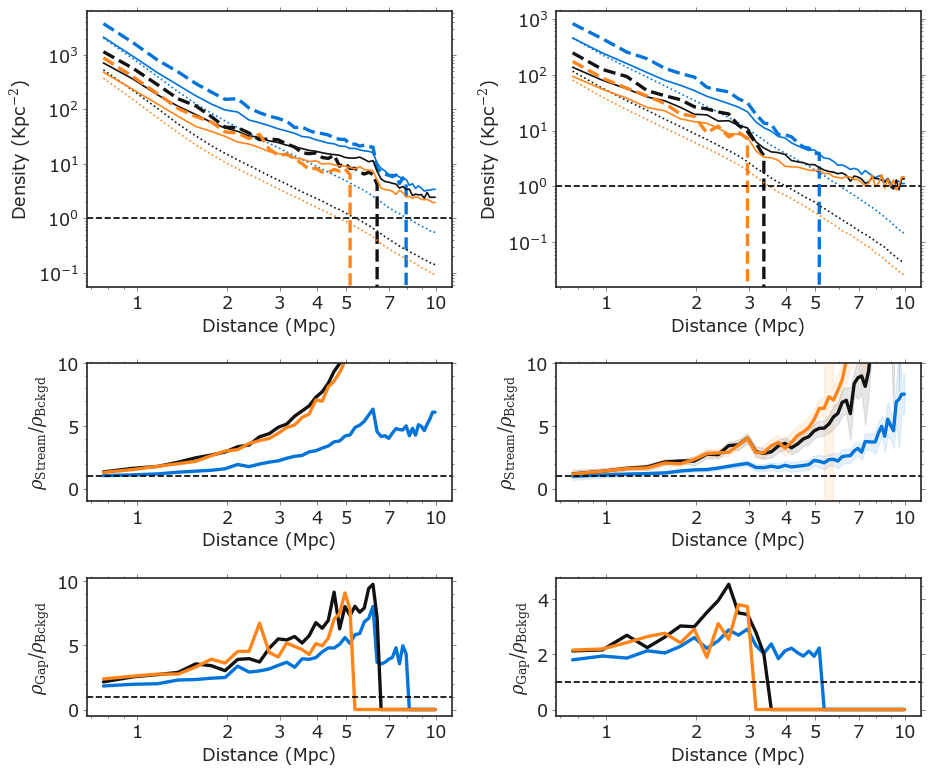

In [218]:
fig, ax=plt.subplots(figsize=(12, 10), ncols=2, nrows=3, sharex='row', height_ratios=[1., 0.5, 0.5])

for rgc in ['10_20', '30_40', '50_60']:
    
    vls=get_counts(df, dgrid,rgc, 28.69)
  
    rgcx=int(np.nanmedian(np.array(rgc.split('_')).astype(float)))

    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], np.vstack(vls['stream_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['gap_dens'])[:,0], np.vstack(vls['gap_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='--', label='Gap, Rgc={} Kpc'.format(rgcx), linewidth=3)
    
    make_line_plot( ax[0][0], dgrid[:-1], np.vstack(vls['bck_dens'])[:,0], np.vstack(vls['bck_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle=':', label='Background, Rgc={} Kpc'.format(rgcx))
    
    
    make_line_plot( ax[2][0], dgrid[:-1], np.vstack(vls['gap_stream_ratio'])[:,0], np.vstack(vls['gap_stream_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-',  linewidth=3, label='Rgc={} Kpc'.format(rgcx))

    make_line_plot( ax[1][0], dgrid[:-1], np.vstack(vls['stream_bck_ratio'])[:,0], np.vstack(vls['stream_bck_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-',  linewidth=3,label='Rgc={} Kpc'.format(rgcx))


    vls=get_counts(df, dgrid,rgc, 27.15)
    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['stream_dens'])[:,0], np.vstack(vls['stream_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-', label='Stream, Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['gap_dens'])[:,0], np.vstack(vls['gap_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle='--', label='Gap, Rgc={} Kpc'.format(rgcx), linewidth=3)
    
    make_line_plot( ax[0][1], dgrid[:-1], np.vstack(vls['bck_dens'])[:,0], np.vstack(vls['bck_dens'])[:,1],\
                   rgc, color=colors[rgc], linestyle=':', label='Background, Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[2][1], dgrid[:-1], np.vstack(vls['gap_stream_ratio'])[:,0], np.vstack(vls['gap_stream_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-',  linewidth=3, label='Rgc={} Kpc'.format(rgcx))
    
    make_line_plot( ax[1][1], dgrid[:-1], np.vstack(vls['stream_bck_ratio'])[:,0], np.vstack(vls['stream_bck_ratio'])[:,1],\
                   rgc, color=colors[rgc], linestyle='-',  linewidth=3, label='Rgc={} Kpc'.format(rgcx), show_error=True)


#ax[1][0].axhline(1, linestyle='--', color='k')
#ax[1][1].axhline(1, linestyle='--', color='k')
for a in np.concatenate(ax):
    a.minorticks_on()
    a.set(xscale='log',  xticks=[1, 2, 3, 4, 5, 7, 10],xticklabels=[1, 2, 3, 4, 5, 7, 10], xlabel='Distance (Mpc)')
   

for a in ax[0]:
    a.set(yscale='log')
    #a.legend(fontsize=10, loc='upper right')
    a.axhline(1, linestyle='--', c='k')
    
for a in ax[1]:
    a.axhline(1, linestyle='--', c='k')
    a.set(ylim=[-1, 10])
    #a.legend(fontsize=10)

for a in ax[-1]:
    a.axhline(1, linestyle='--', c='k')
    #a.legend(fontsize=10)

#ax[0][0].set(yscale='log', ylim=[1e-1, 5e3])
#ax[0][1].set(yscale='log', ylim=[1e-1, 5e3])

ax[0][0].set(ylabel=r'Density (Kpc$^{-2}$)')
ax[0][1].set(ylabel=r'Density (Kpc$^{-2}$)')


ax[2][0].set(ylabel=r'$\rho_{\rm Gap}/\rho_{\rm Bckgd }$')
ax[2][1].set(ylabel=r'$\rho_{\rm Gap}/\rho_{\rm Bckgd }$')

ax[1][0].set(ylabel=r'$\rho_{\rm Stream}/\rho_{\rm Bckgd }$')
ax[1][1].set(ylabel=r'$\rho_{\rm Stream}/\rho_{\rm Bckgd }$')

#ax[1][0].set(ylim=[-2, 2])
#ax[1][1].set(ylim=[-2, 2])
plt.tight_layout()

plt.savefig('../figures/gap_density_number.pdf')

In [139]:
def get_pipeline_results(dmod, mag_limit, rgc):
    fls=glob.glob('../data/pipeline/pipeline_rgc{}_mhalo5.00e+06_maglimit{:.2f}_run*.npy'.format(rgc, mag_limit))
    #print (fls
    res=None
    for f in fls:
        c=np.load(f, allow_pickle=True)
        for vls in c:
            for k in vls.keys():
                bw=(k.split('dmod_galaxy')[0]).split('bw')[-1]
                dmodx=float(k.split('dmod_galaxy')[-1])
                if (dmod ==dmodx) and (bw=='0.7'):
                    return vls[k]
                else:
                    continue

def get_pipeline_results_full(dmod, mag_limit, rgc):
    fls=glob.glob('../data/pipeline/pipeline_rgc{}_mhalo5.00e+06_maglimit{:.2f}_run*.npy'.format(rgc, mag_limit))
    #print (fls
    res=[]
    for f in fls:
        c=np.load(f, allow_pickle=True)
        for vls in c:
            for k in vls.keys():
                bw=(k.split('dmod_galaxy')[0]).split('bw')[-1]
                dmodx=float(k.split('dmod_galaxy')[-1])
                if (dmod ==dmodx) and (bw=='0.7'):
                    res.append(vls[k])
                else:
                    continue
    return res
res=get_pipeline_results(24.06, 28.69, '10_20')

In [140]:
res=get_pipeline_results_full(24.06, 28.69, '10_20')
#res

In [141]:
dmods=np.unique(df.dmod.values[np.logical_and(df.distance/1e6 <10, df.distance/1e6 > 0.7) ])[::6]

In [142]:
len(dmods)

23

In [143]:
 from matplotlib import patches

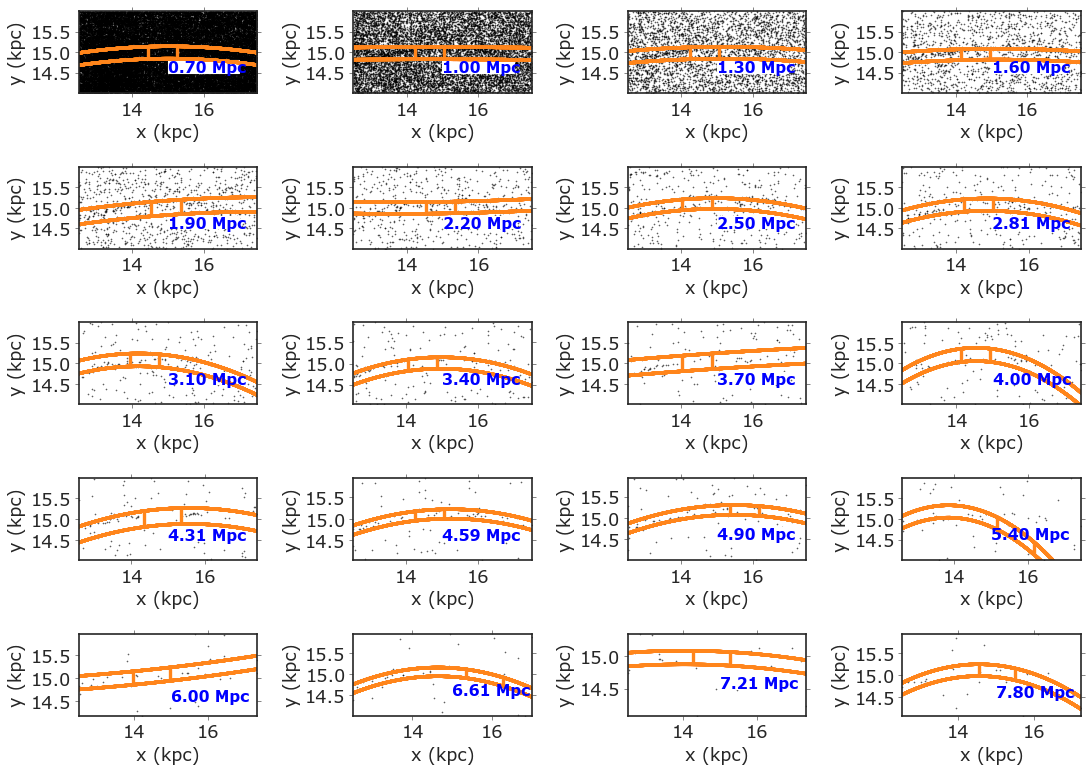

In [144]:
fig, ax=plt.subplots(ncols=4, nrows=int(len(dmods)/4), figsize=(14, 2*int(len(dmods)/4)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    res=get_pipeline_results(dmod, 28.69, '10_20')
    _=show_gap_detection(res,  plot='plot3', ax=a)
    title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    
    rect = patches.Rectangle( (15,14.5), \
                               2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(15, 14.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc15.jpeg')

In [145]:
#plt.hist(df.spread_stream_stars.values)

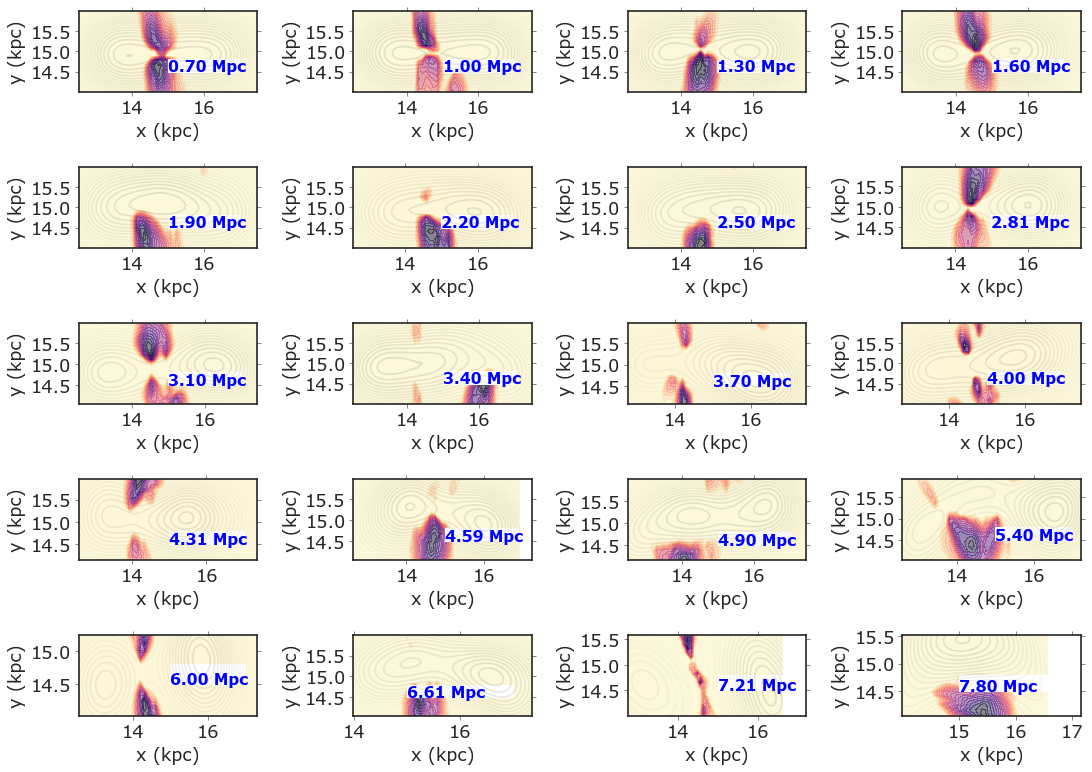

In [146]:
fig, ax=plt.subplots(ncols=4, nrows=int(len(dmods)/4), figsize=(14, 2*int(len(dmods)/4)))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods[idx]
    res=get_pipeline_results(dmod, 27.15, '10_20')
    _=show_gap_detection(res,  plot='plot6', ax=a)
    #resx=get_pipeline_results_full(dmod, 28.69, '10_20')
    #for res in resx:
    #    _=show_gap_detection(res,  plot='plot6', ax=a)
    title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1)))
    
    rect = patches.Rectangle( (15,14.5), \
                               2, 0.3, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(15, 14.5, title,\
           color='b', alpha=1, fontsize=14, weight='bold')
    a.set(xlabel='x (kpc)', ylabel='y (kpc)')
#ax.scatter(res['meshgrid'][0], res['meshgrid'][1], marker='+', alpha=0.1)
plt.tight_layout()
plt.savefig('../figures/visual_detections_rgc15_piHpi.jpeg')

In [147]:
from popsims.plot_tools import plot_annotated_heatmap


In [148]:

#df['prod']=df.spread_gap_stars/df.spread_stream_stars
df.offset_center=np.abs(df.offset_center)

In [149]:
df.shape

(104608, 18)

In [150]:
import matplotlib as mpl

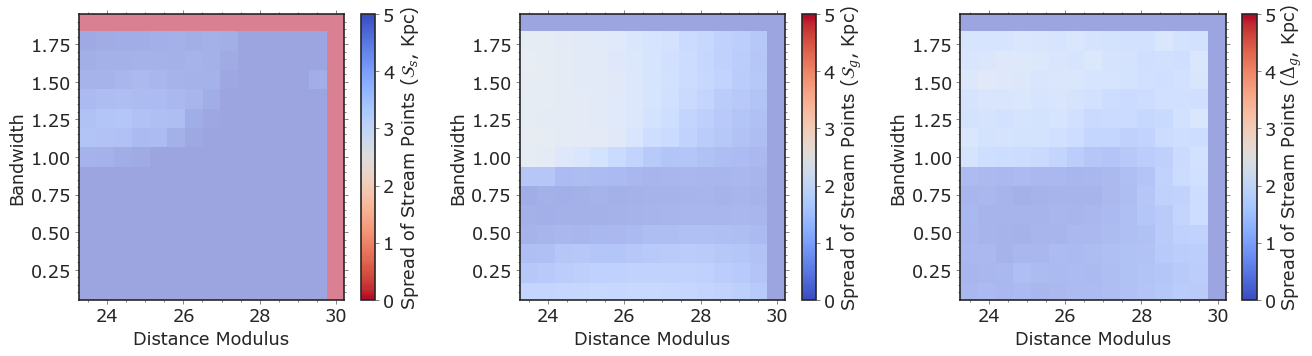

In [151]:
fig, ax=plt.subplots(ncols=3, figsize=(14*1.2, 4*1.2))

#ax[0].scatter(  df.dmod, df.bw, c=df.spread_gap_stars , s=0.1, cmap='cubehelix')
#ax[1].scatter(df.dmod, df.bw, c=df.spread_stream_stars, s=0.1, cmap='cubehelix')

plot_annotated_heatmap(ax[0], df, 15, ['dmod', 'bw', 'spread_stream_stars'], vmin=0., vmax=0.2, cmap='coolwarm_r',annotate=True,  alpha=0.5)


plot_annotated_heatmap(ax[1], df, 15, ['dmod', 'bw', 'spread_gap_stars'], vmin=0.0, vmax=5., cmap='coolwarm',annotate=False, alpha=0.5)
plot_annotated_heatmap(ax[-1], df, 15, ['dmod', 'bw', 'offset_center'], vmin=0.0, vmax=5., cmap='coolwarm',annotate=False, alpha=0.5)

#ax[0].scatter(df.dmod, df.bw, s=.1)

cmap = mpl.cm.coolwarm_r
norm = mpl.colors.Normalize(vmin=0, vmax=5)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[0], orientation='vertical', label=r'Spread of Stream Points ($\mathcal{S}_s$, Kpc)')

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=5)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], orientation='vertical', label=r'Spread of Stream Points ($\mathcal{S}_g$, Kpc)')

cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=5)
plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[-1], orientation='vertical', label=r'Spread of Stream Points ($\Delta_g$, Kpc)')

for a in ax:
    a.set(ylim=[0.05, 1.95], xlabel='Distance Modulus', ylabel='Bandwidth')


plt.tight_layout()

plt.savefig('../figures/gaps_spread_all_bws.pdf', bbox_inches='tight')


In [179]:
df.bw.min()

0.0

In [153]:
ds=([0.77, 1., 1.5, 2., 2.5, 3.])*u.Mpc
dmods2 = 5*np.log10(ds.to(u.pc)/(10*u.pc)).value

dmods2

array([24.43245363, 25.        , 25.8804563 , 26.50514998, 26.98970004,
       27.38560627])

In [154]:
dmods2=[ 24.52,  25.  , 25.88, 26.51, 26.99, 27.39]

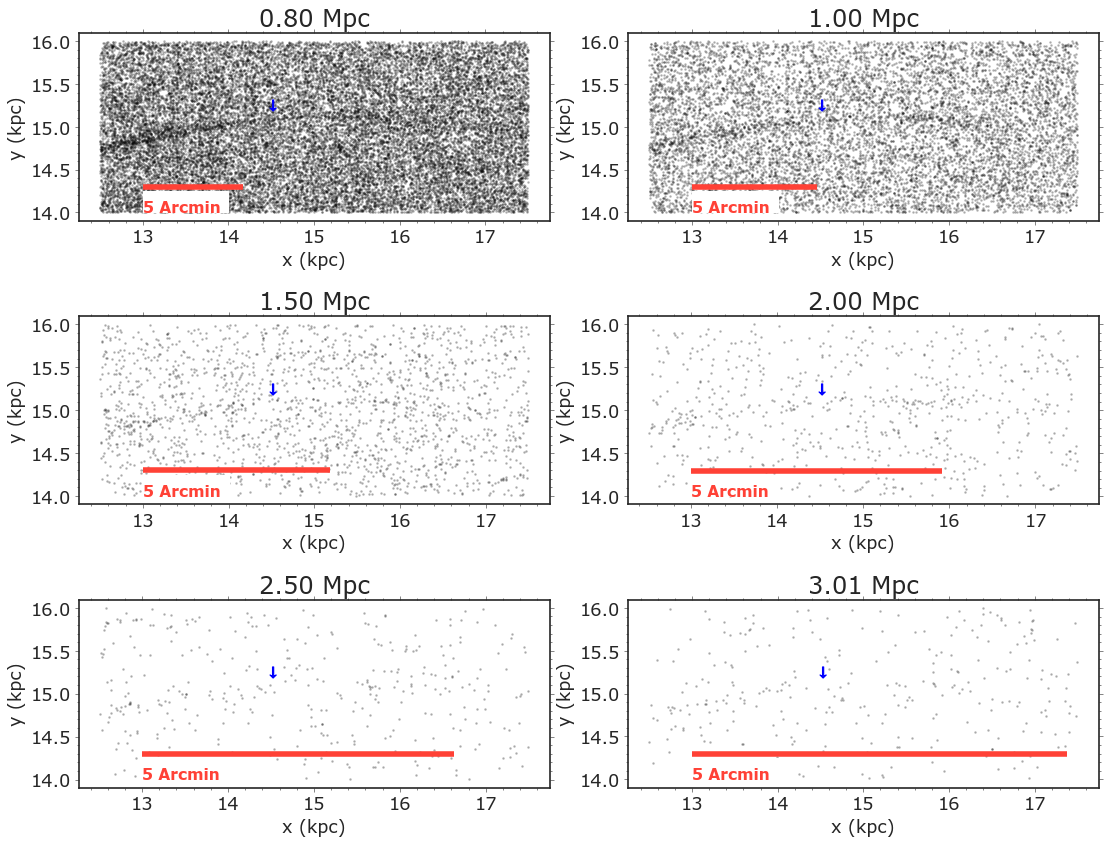

In [155]:
fig, ax=plt.subplots(nrows=3, ncols=2, figsize=(14, 10.9))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=dmods2[idx]
    
    res=get_pipeline_results(dmod, 28.69, '10_20')
    #_=show_gap_detection(res,  plot='plot3', ax=a)
    dmod=float(dmod)
    #print(dmod)
    a.scatter(res['data'][:,0], res['data'][:,1], s=2, alpha=0.2, c='k')
    a.minorticks_on()
    a.axis('equal')
    
    d_galaxy=(1e-3*(10**((dmod/5)+1)))*u.kpc
    kpc_conversion = np.pi * d_galaxy / 180.
    roman_fov= 0.52*u.degree*(kpc_conversion /u.degree)
    scaled_arcmin= 5*u.arcmin.to(u.degree)*(kpc_conversion /u.degree).value
    
    
    a.hlines(y=14.3, xmin= 13, xmax=13+scaled_arcmin, \
             linewidth=5, color='#FF4136')
    
    rect = patches.Rectangle( (13,14), \
                               1, 0.25, linewidth=1, edgecolor='#FFFFFF', facecolor='#FFFFFF')
    a.add_patch(rect)
    a.text(13, 14., '5 Arcmin',\
           color='#FF4136', alpha=1, fontsize=14, weight='bold')
    
    a.scatter(14.5,  15.0+0.25, color='b', marker='$\u2193$', s=100)

    a.set(title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1))), xlabel='x (kpc)', ylabel='y (kpc)')

plt.tight_layout()
plt.savefig('../figures/gaps_visual_detections.jpeg')

In [156]:
10**((dmods2[0]/5)+1)

801678.0633876789

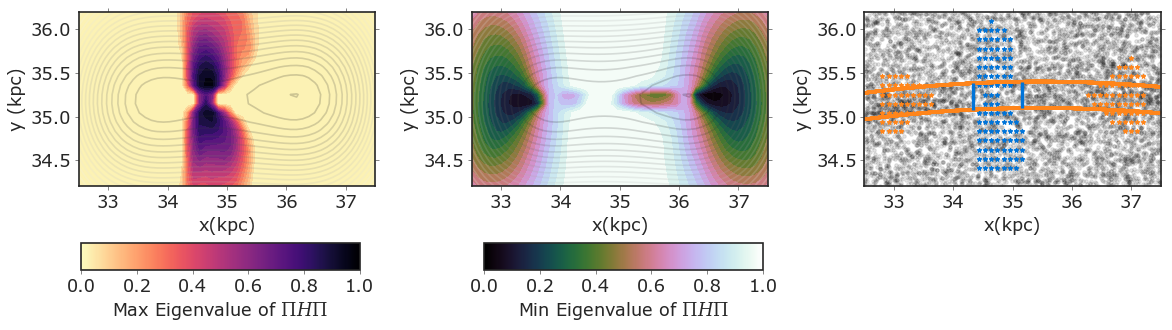

In [157]:
res=get_pipeline_results(dmods2[0], 28.69, '30_40')

import matplotlib as mpl

fig, ax=plt.subplots(ncols=3, figsize=(10*1.5, 2.25*1.5))

#ax[-1].scatter(res['data'][:,0], res['data'][:,1], s=0.1, alpha=1, c='k')
_= show_gap_detection(res,  plot='plot1', ax=ax[0])
_= show_gap_detection(res,  plot='plot2', ax=ax[1])
_= show_gap_detection(res,  plot='plot4', ax=ax[-1])


cmap = mpl.cm.magma_r
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.079, -0.05, 0.232, 0.1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Max Eigenvalue of $\Pi H \Pi$')


cmap = mpl.cm.cubehelix
norm = mpl.colors.Normalize(vmin=0, vmax=1)
cax = fig.add_axes([0.415, -0.05, 0.232, 0.1])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label=r'Min Eigenvalue of $\Pi H \Pi$')

for a in ax:
    a.set(xlabel='x(kpc)', ylabel='y (kpc)')
    #a.axis('equal')
plt.tight_layout()

plt.savefig('../figures/stream_cutout.jpeg', bbox_inches='tight')

In [158]:
def get_nsimulated(mlimit):
    
    from popsims import sample_from_powerlaw
    import scipy.interpolate as interp
    path_isochrone='../data/isochrones/'
    isochrone_path=path_isochrone
    mag_keys=['gmag', 'imag', 'F062mag', 'F087mag']
    from scipy.interpolate import interp1d, griddata
    from tqdm import tqdm
    
    
    def count_pal5_stars_old(mag_limit, dmod):
            dmod_pal5=16.85
            cfht_mini = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
            cfht_gmag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [24])
            cfht_imag = np.loadtxt(isochrone_path+'/Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [25])
            wfirst_mini = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
            wfirst_mags = np.loadtxt(isochrone_path+'/Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [23,24,25,26,27,28,29])

            sample_lowmasses=sample_from_powerlaw(-0.5, xmin=np.min(cfht_mini), xmax=np.max(cfht_mini), nsample=int(1e6)) 
            inter_gmags = interp.interp1d(cfht_mini, cfht_gmag, bounds_error=False,  fill_value=np.nan)
            inter_imags = interp.interp1d(cfht_mini, cfht_imag, bounds_error=False,  fill_value=np.nan)
            inter_Rmags = interp.interp1d(wfirst_mini, wfirst_mags[:,0], bounds_error=False,  fill_value=np.nan)
            inter_Zmags = interp.interp1d(wfirst_mini, wfirst_mags[:,1], bounds_error=False,  fill_value=np.nan)
            inter_Ymags = interp.interp1d(wfirst_mini, wfirst_mags[:,2], bounds_error=False,  fill_value=np.nan)
            inter_Jmags = interp.interp1d(wfirst_mini, wfirst_mags[:,3], bounds_error=False,  fill_value=np.nan)
            inter_Hmags = interp.interp1d(wfirst_mini, wfirst_mags[:,4], bounds_error=False,  fill_value=np.nan)
            inter_Fmags = interp.interp1d(wfirst_mini, wfirst_mags[:,5], bounds_error=False,  fill_value=np.nan)
            inter_Wmags = interp.interp1d(wfirst_mini, wfirst_mags[:,6], bounds_error=False,  fill_value=np.nan)

            if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
                print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
            else:    
                #CFHT magnitudes
                sample_gmags = inter_gmags(sample_lowmasses) +  dmod_pal5  #distance modulus Pal5
                sample_imags = inter_imags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
                #WFIRST magnitudes
                sample_Rmags = inter_Rmags(sample_lowmasses) +  dmod_pal5  #distance modulus Pal5
                sample_Zmags = inter_Zmags(sample_lowmasses)+  dmod_pal5 #distance modulus Pal5
                sample_Ymags = inter_Ymags(sample_lowmasses)  +  dmod_pal5 
                sample_Jmags = inter_Jmags(sample_lowmasses)+  dmod_pal5  #distance modulus Pal5
                sample_Hmags = inter_Hmags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5
                sample_Fmags = inter_Fmags(sample_lowmasses)+  dmod_pal5 #distance modulus Pal5
                sample_Wmags = inter_Wmags(sample_lowmasses) +  dmod_pal5 #distance modulus Pal5

                #renormalize the luminosity function by computing a normalization factor
                num_20_23= len(sample_gmags[np.logical_and(sample_gmags>=20, sample_gmags<=23)])
                #print ('number of stars between 20 and 23 G mag {}'.format( num_20_23))

                norm= 3000/num_20_23
                #print (norm)

                #compute the difference between distance moduli and offset stars
                dist_mod_And = dmod-dmod_pal5
                #offset_Zmags= sample_Zmags+  dist_mod_And
                nstars_wfirst = (len(np.where((sample_Zmags < (mag_limit-dist_mod_And)  ))[0]))*norm

                #fig, ax=plt.subplots()
                #plt.scatter( sample_lowmasses, sample_gmags)
                #ax.set(ylabel=k, xlabel='Mass ')
                #j
                return nstars_wfirst
        
    ns=[]

    ds=np.arange(500, 10000, 50)*u.kpc
    dmods=5*np.log10(ds.to(u.pc).value/10.0)

    for dmod in tqdm(dmods):
        ns.append(count_pal5_stars_old(mlimit, dmod))

    return ns

In [159]:
ns0=get_nsimulated(28.69)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [01:26<00:00,  2.20it/s]


In [160]:
ns1=get_nsimulated(27.15)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [01:23<00:00,  2.28it/s]


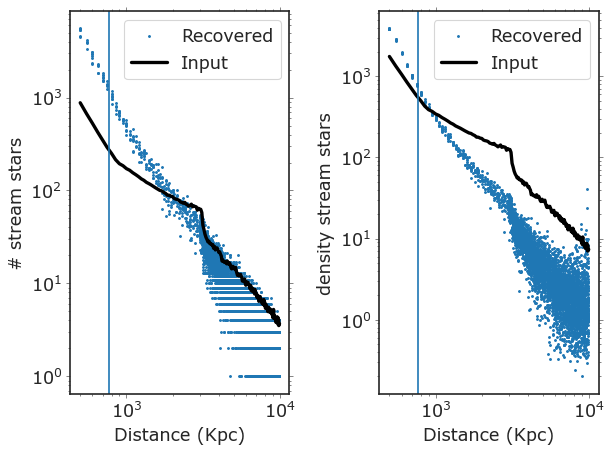

In [161]:
#Compare stream numbers to recovered number 

fig, (ax, ax1)=plt.subplots(ncols=2)

mask=np.logical_and.reduce([(df.mag_limit==27.15).values, (df.bw==0.7).values, (df.rgc=='10_20').values])
ax.scatter(df.distance[mask]/1e3, df.nstars_stream[mask], marker='.', s=10, label='Recovered')
ax.plot(np.arange(500, 10000, 50), ns1, c='k', linewidth=3, label='Input')


ax1.scatter(df.distance[mask]/1e3, df.stream_dens[mask], marker='.', s=10, label='Recovered')
ax1.plot(np.arange(500, 10000, 50), np.array(ns1)/(0.1*5), c='k', linewidth=3, label='Input')



for a in (ax, ax1):
    a.axvline(0.77e3)
    a.legend()
    a.set(yscale='log', xscale='log', xlabel='Distance (Kpc)')
    
ax.set(ylabel='# stream stars')
ax1.set(ylabel='density stream stars')
plt.tight_layout()
plt.savefig('../figures/diagnostic_counts.jpeg', bbox_inches='tight')

In [162]:
bck=read_backgrounds_file(27.15, '10_20')


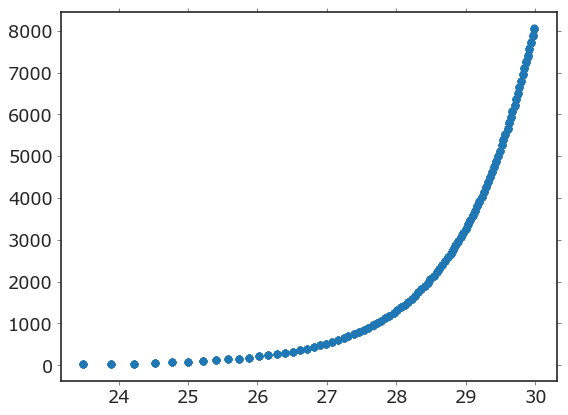

In [163]:
fig, ax=plt.subplots()
plt.scatter(bck.dmod, bck.area)

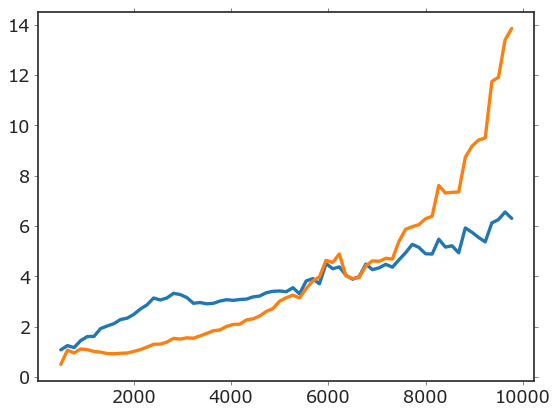

In [164]:

def interpolated_values(xgrid, x, y):
    return np.interp(xgrid, x, y) 

mask=np.logical_and.reduce([(df.mag_limit==27.15).values, (df.bw==0.7).values, (df.rgc=='10_20').values])
bck['distance']=10**((bck.dmod.values/5)+1)

y_bck=[]
y_bck_new=[]
y_st=[]

xgrid=np.linspace(np.unique(df.distance/1e3).min(), np.unique(df.distance/1e3).max(), 70)

for idx in range(len(xgrid)-1):
    v=df[np.logical_and(df.distance/1e3>=xgrid[idx], df.distance/1e3<xgrid[idx+1])]
    y_bck.append(np.nanmedian(v.bck_dens))
    y_st.append(np.nanmedian(v.stream_dens))
    
    v2=bck[np.logical_and(bck.distance/1e3>=xgrid[idx], bck.distance/1e3<xgrid[idx+1])]
    y_bck_new.append(np.nanmedian(v2.density))
    
y1_bck=interpolated_values(xgrid[:-1], xgrid[:-1], y_bck)
y1_st=interpolated_values(xgrid[:-1], xgrid[:-1], y_st)
y2_bck_new=interpolated_values(xgrid[:-1], xgrid[:-1], y_bck_new)
#y2=interpolated_values(xgrid[::1],(df.distance[mas]/1e3).values, ((df.bck_dens)[mask]).values)
#y3=interpolated_values(xgrid,(bck.distance/1e3).values, (bck.density).values)
fig, ax=plt.subplots()
#ax.plot(xgrid[:-1], y1_bck, linewidth=3)
#ax.plot(xgrid[:-1], y1_st, linewidth=3)

ax.plot(xgrid[:-1], y1_st/y1_bck, linewidth=3)
ax.plot(xgrid[:-1], y1_st/y2_bck_new, linewidth=3)

#ax.set_yscale('log')
        

[None, None, Text(0, 0.5, 'Density'), Text(0.5, 0, 'Distance (Kpc)')]

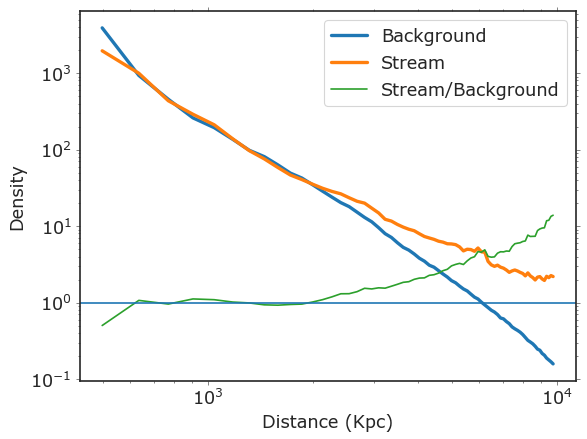

In [165]:

fig, ax=plt.subplots()

#ax.scatter(df.distance[mask]/1e3, (df.stream_dens)[mask], marker='.', s=10, label='Stream recovered')

#ax.scatter(df.distance[mask]/1e3, (df.bck_dens)[mask], s=10, label='Bckgd recovered')

#ax.scatter(bck.distance/1e3, bck.density, label='Bckgd Full FOV', c='k')


ax.plot(xgrid[:-1], y2_bck_new, linewidth=3, label='Background')

ax.plot(xgrid[:-1], y1_st, linewidth=3, label='Stream')
ax.plot(xgrid[:-1], y1_st/y2_bck_new, label='Stream/Background')


#ax.plot(np.arange(500, 10000, 50), np.array(ns1)/(0.1*5), c='k', linewidth=3, label='Input')

ax.legend()
ax.axhline(1)

ax.set(yscale='log', xscale='log', ylabel='Density', xlabel='Distance (Kpc)')

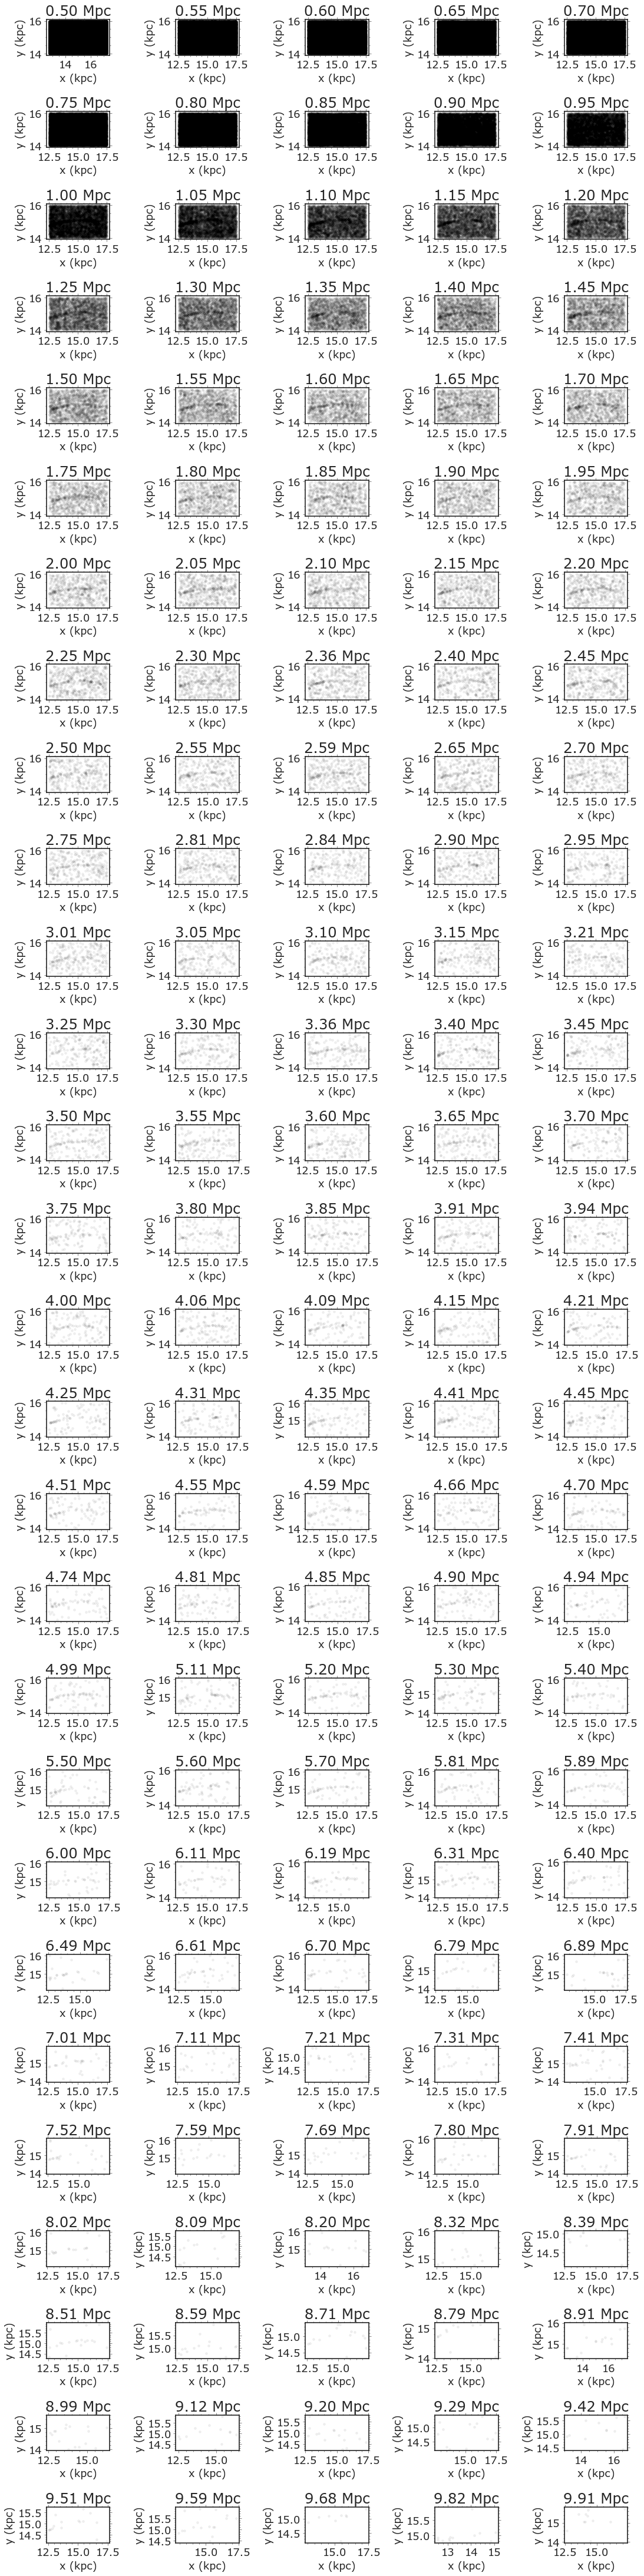

In [170]:
raw_dens=[]
fig, ax=plt.subplots(nrows=28, ncols=5, figsize=(14, 55))

axs= np.concatenate(ax)
for idx in range(len(axs)):
    a=axs[idx]
    dmod=np.unique(df.dmod)[idx]
    
    res=get_pipeline_results(dmod, 28.69, '10_20')
    #_=show_gap_detection(res,  plot='plot3', ax=a
    dmod=float(dmod)
    area=np.ptp(res['data'][:,0])*np.ptp(res['data'][:,1])
    raw_dens.append([dmod, len(res['data'][:,0])/area])
    #print(dmod)
    a.scatter(res['data'][:,0], res['data'][:,1], s=10., alpha=0.05, c='k')
    a.minorticks_on()
    #a.axis('equal')
  
    a.set(title='{:.2f} Mpc'.format(1e-6*(10**((dmod/5)+1))), xlabel='x (kpc)', ylabel='y (kpc)')

plt.tight_layout()

In [171]:
bck=read_backgrounds_file(28.69, '10_20')


[None]

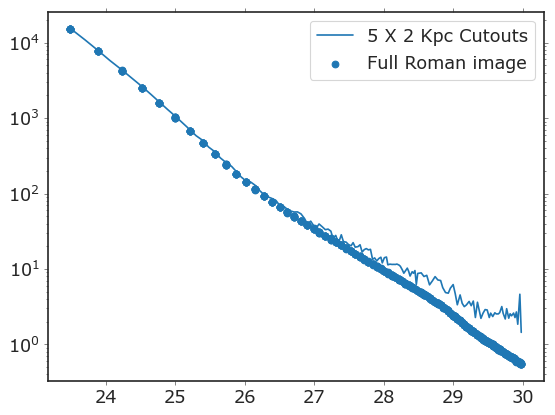

In [176]:
fig, ax=plt.subplots()
plt.plot(np.vstack(raw_dens)[:,0],np.vstack(raw_dens)[:,1], label='5 X 2 Kpc Cutouts') 
plt.scatter(bck.dmod, bck.density, label='Full Roman image')
plt.legend()
#ax.set(yscale='log')

In [181]:
fnp.unique(bck.dmod.values)

array([23.49, 23.89, 24.23, 24.52, 24.77, 25.  , 25.21, 25.4 , 25.57,
       25.73, 25.88, 26.02, 26.15, 26.28, 26.39, 26.51, 26.61, 26.71,
       26.81, 26.9 , 26.99, 27.07, 27.16, 27.24, 27.31, 27.39, 27.46,
       27.53, 27.59, 27.66, 27.72, 27.78, 27.84, 27.9 , 27.96, 28.01,
       28.06, 28.12, 28.17, 28.22, 28.27, 28.31, 28.36, 28.41, 28.45,
       28.49, 28.54, 28.58, 28.62, 28.66, 28.7 , 28.74, 28.78, 28.82,
       28.85, 28.89, 28.93, 28.96, 29.  , 29.03, 29.06, 29.1 , 29.13,
       29.16, 29.19, 29.23, 29.26, 29.29, 29.32, 29.35, 29.38, 29.4 ,
       29.43, 29.46, 29.49, 29.52, 29.54, 29.57, 29.6 , 29.62, 29.65,
       29.67, 29.7 , 29.72, 29.75, 29.77, 29.8 , 29.82, 29.84, 29.87,
       29.89, 29.91, 29.93, 29.96, 29.98])

{'spread_stream_stars': 0.27577227863113585,
 'spread_gap_stars': 0.47853365180025204,
 'nstars_gap': 3,
 'nstars_stream': 13,
 'nstars_bck': 6,
 'stream_area': 1.3788613931556792,
 'gap_area': 0.13788613931556792,
 'bck_area': 8.644444444444444,
 'stream_dens': 9.42806874173773,
 'gap_dens': 21.757081711702458,
 'bck_dens': 0.6940874035989718,
 'offset_center': -0.43488298720104623}

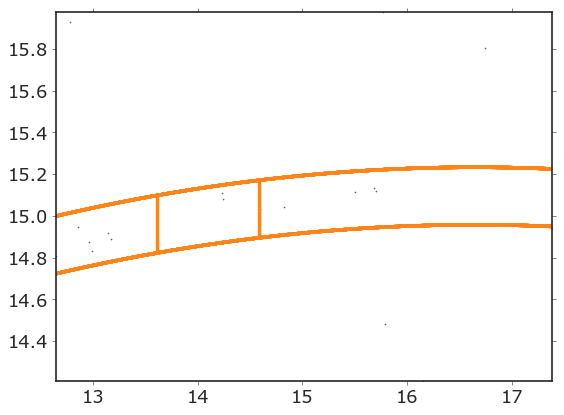

In [189]:
fig, ax=plt.subplots()
res=get_pipeline_results(29.52, 28.69, '10_20')
show_gap_detection(res,  plot='plot3', ax=ax)

In [191]:
13/1.3

10.0

In [193]:
bckx=read_backgrounds_file(28.69, '10_20')

In [197]:
bckx_sm=bckx[bckx.dmod==29.52]

In [198]:
bckx_sm.density

75     1.058579
170    1.048548
265    1.052319
360    1.038822
455    1.053124
551    1.053149
Name: density, dtype: float64

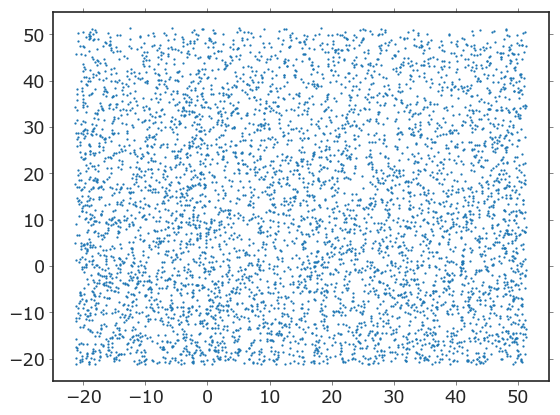

In [207]:
fig, ax=plt.subplots()

ax.scatter(bckx_sm.data.iloc[0][0], bckx_sm.data.iloc[0][1], s=1)

In [209]:
len(bckx_sm.data.iloc[0][0])

5574

In [210]:
70**2

4900